Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Caption: dit is een fragment van een mammoetkies.


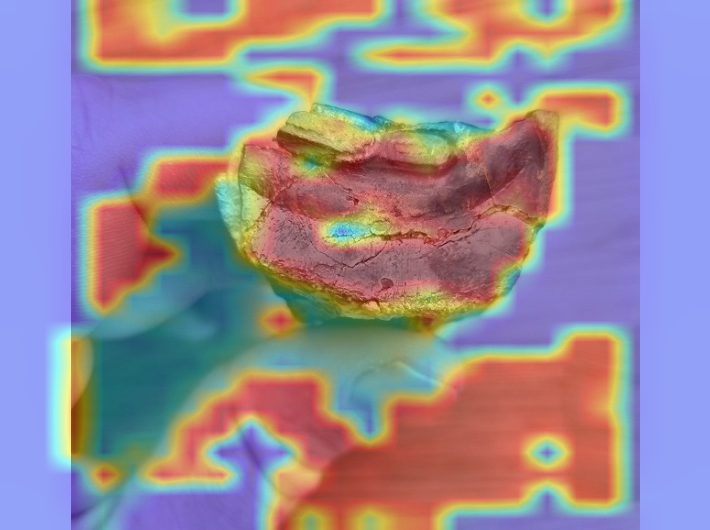

Done


In [16]:
"""
AtA (Agent-to-Agent) notebook rewrite using BLIP for captioning + Grad-CAM explainability.

Features:
- Fine-tune BLIP-2 (base/small) on your image->caption JSON dataset (HuggingFace Trainer).
- Inference agents: CaptionAgent (BLIP generate) and ExplainAgent (cross-attention heatmap).
- Grad-CAM that hooks BLIP cross-attention and produces a 2D heatmap overlay.

Notes:
- Requires GPU for training; use fp16 if available. Adjust batch sizes to your GPU memory.
- This file assumes dataset JSON mapping: {"img.jpg": "caption text", ...} located at json_path.

"""

# === Imports ===
import os
import json
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt

from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer
from datasets import Dataset as HFDataset

# === Config ===
json_path = "dataset/dataset.json"         
image_folder = "dataset/images/"        
model_name = "Salesforce/blip-image-captioning-base"  # change to -small if memory limited
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training hyperparams
per_device_train_batch_size = 4
gradient_accumulation_steps = 2
num_train_epochs = 5
learning_rate = 1e-5
output_dir = "blip_finetuned"

# === Utilities ===
class SimpleCaptionDataset(Dataset):
    def __init__(self, json_file, images_dir, processor):
        with open(json_file, 'r') as f:
            data = json.load(f)
        # data expected as {"img.jpg": "caption"}
        self.items = list(data.items())
        self.images_dir = images_dir
        self.processor = processor

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_name, caption = self.items[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        # processor will be used in collate
        return {"image": image, "caption": caption, "img_name": img_name}

# Collate for trainer (returns pixel_values and labels)
def collate_fn(batch, processor):
    images = [b["image"] for b in batch]
    captions = [b["caption"] for b in batch]
    enc = processor(images=images, text=captions, return_tensors="pt", padding=True)
    # enc contains pixel_values and input_ids (decoder) depending on processor
    # Ensure labels are set: replace pad token id with -100
    labels = enc["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    return {
        "pixel_values": enc["pixel_values"],
        "labels": labels
    }

# === Training helper (HuggingFace Trainer) ===
def prepare_hf_dataset(json_path, image_folder, processor):
    ds = SimpleCaptionDataset(json_path, image_folder, processor)
    # convert to HF dataset wrapper for Trainer convenience
    records = []
    for item in ds:
        # store image path and caption text
        records.append({"image": item["image"], "caption": item["caption"]})
    # Note: HF dataset can store PIL images in memory; Trainer will use collate_fn provided
    hf = HFDataset.from_list(records)
    return hf


def train_blip(json_path=json_path, image_folder=image_folder, model_name=model_name, out_dir=output_dir):
    print("Loading processor and model:", model_name)
    processor = BlipProcessor.from_pretrained(model_name)
    model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

    # Freeze most params then unfreeze last layers if desired
    for p in model.parameters():
        p.requires_grad = False

    # Heuristic: unfreeze last 3 vision blocks + cross-attention + LM head
    try:
        vision = model.vision_model
        # some BLIP variants: vision_model.encoder.layer
        blocks = getattr(vision, 'encoder').layer if hasattr(getattr(vision, 'encoder', None), 'layer') else vision.transformer.resblocks
        for blk in blocks[-3:]:
            for p in blk.parameters():
                p.requires_grad = True
    except Exception:
        # fallback: try model.vision_model.transformer.resblocks
        try:
            for blk in model.vision_model.transformer.resblocks[-3:]:
                for p in blk.parameters():
                    p.requires_grad = True
        except Exception:
            print("Warning: could not auto-unfreeze vision blocks; you may unfreeze manually.")

    # Unfreeze LM head
    for name, p in model.named_parameters():
        if "lm_head" in name or "qformer" in name or "text" in name:
            p.requires_grad = True

    processor = BlipProcessor.from_pretrained(model_name)
    hf_ds = prepare_hf_dataset(json_path, image_folder, processor)

    training_args = TrainingArguments(
        output_dir=out_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        fp16=torch.cuda.is_available(),
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        save_strategy="epoch",
        logging_steps=100,
        remove_unused_columns=False,
    )

    def data_collator(batch):
        return collate_fn(batch, processor)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=hf_ds,
        data_collator=data_collator,
    )

    trainer.train()
    trainer.save_model(out_dir)
    processor.save_pretrained(out_dir)
    print("Saved fine-tuned BLIP to", out_dir)
    return out_dir

# === Inference / Agent integration ===
# Load processor + model (finetuned path)

def load_blip_model(model_dir=output_dir):
    
    processor = BlipProcessor.from_pretrained(model_dir)
    model = BlipForConditionalGeneration.from_pretrained(model_dir).to(device)
    model.eval()
    '''
    model_path = "blip-finetuned-fossils"
    processor = BlipProcessor.from_pretrained(model_path)
    model = BlipForConditionalGeneration.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    '''
    return processor, model

# Simple caption agent
def make_caption_agent(processor, model):
    def caption_agent(message):
        image = message["image"]
        inputs = processor(image, return_tensors="pt").to(device)
        with torch.no_grad():
            out_ids = model.generate(**inputs, max_new_tokens=40)
        caption = processor.decode(out_ids[0], skip_special_tokens=True)
        message["caption"] = caption
        return message
    return caption_agent

# === Grad-CAM for BLIP cross-attention (fixed) ===
class BlipCrossAttnGradCAM:
    def __init__(self, blip_model, processor, device=None):
        self.device = device if device is not None else next(blip_model.parameters()).device
        self.model = blip_model.to(self.device)
        self.processor = processor
        self.attn_maps = []
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        self.attn_maps = []
        self.hooks = []
        try:
            decoder = (
                self.model.text_decoder 
                if hasattr(self.model, 'text_decoder') 
                else self.model.decoder
            )
            layers = decoder.bert.encoder.layer

            for L in layers:
                ca = getattr(L, 'crossattention', None)
                if ca is None:
                    continue

                def make_hook():
                    def hook(module, inp, out):
                        # HF returns (output, attn_weights)
                        if isinstance(out, tuple) and len(out) >= 2:
                            self.attn_maps.append(out[1])
                    return hook

                h = ca.register_forward_hook(make_hook())
                self.hooks.append(h)

        except Exception as e:
            print("Hook registration failed:", e)

    def generate(self, pil_image, prompt=None):
        # Reset attention storage
        self.attn_maps = []

        text = prompt if prompt is not None else "Explain this image"
        inputs = self.processor(pil_image, text=text, return_tensors="pt").to(self.device)

        with torch.no_grad():
            _ = self.model(**inputs)

        if len(self.attn_maps) == 0:
            raise RuntimeError("No attention maps recorded.")

        # Use last attention layer
        attn = self.attn_maps[-1]  # shape: [1, heads, Q, K]

        # Average over heads
        attn = attn.mean(dim=1)  # [1, Q, K]

        # Use attention from first text token → image patches
        patch_attn = attn[0, 0, :]  # shape [K]

        patch_attn = patch_attn.detach().cpu().numpy()

        # === FIX: remove CLS token ===
        patch_attn = patch_attn[1:]  # Now 576 for ViT-L, or 196 for ViT-B

        # Normalize
        patch_attn = patch_attn - patch_attn.min()
        patch_attn = patch_attn / (patch_attn.max() + 1e-8)

        # Infer patch grid (works for 14×14 or 24×24)
        n = patch_attn.shape[0]
        side = int(np.sqrt(n))

        if side * side != n:
            raise ValueError(f"Patch count {n} is not a perfect square. Cannot reshape.")

        heatmap = patch_attn.reshape(side, side)

        # Slight contrast enhancement
        heatmap = heatmap ** 0.3

        return heatmap


# === Visualization ===
def show_gradcam_pil(pil_image, heatmap):
    img = np.array(pil_image)
    hmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    hmap = np.clip(hmap, 0, 1)

    hmap_color = cv2.applyColorMap((hmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    hmap_color = cv2.cvtColor(hmap_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img, 0.6, hmap_color, 0.4, 0)
    return Image.fromarray(overlay)

# === Example: load fine-tuned model (or base) and create agents ===
if __name__ == '__main__':
    # Load base or finetuned
    fine_tuned_dir = "blip-finetuned-fossils"
    proc, bm = load_blip_model(fine_tuned_dir)
    bm.eval()  # ensure model is in eval mode
    '''
    if os.path.isdir(output_dir):
        proc, bm = load_blip_model(output_dir)
    else:
        proc = BlipProcessor.from_pretrained(model_name)
        bm = BlipForConditionalGeneration.from_pretrained(model_name).to(device)
        bm.eval()
    '''
    caption_agent = make_caption_agent(proc, bm)
    gradcam = BlipCrossAttnGradCAM(bm, proc, device=device)

    # Quick test on a single image
    test_img_path = "dataset/images/0002.jpg"
    #test_img_path = next(Path(image_folder).glob('*'))
    pil = Image.open(test_img_path).convert('RGB')
    msg = {"image": pil}
    msg = caption_agent(msg)
    print('Caption:', msg['caption'])
    heat = gradcam.generate(pil, prompt=msg['caption'])
    overlay = show_gradcam_pil(pil, heat)
    display(overlay)

    print('Done')


In [13]:
import os
import json
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, Trainer, TrainingArguments

# ----------------------
# Dataset
# ----------------------
class FossilCaptionDataset(Dataset):
    def __init__(self, json_path, image_folder, processor):
        self.data = json.load(open(json_path))
        self.keys = list(self.data.keys())
        self.image_folder = image_folder
        self.processor = processor

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        img_name = self.keys[idx]
        caption = self.data[img_name]

        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")

        inputs = self.processor(
            images=image,
            text=caption,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
        }

# ----------------------
# Paths and model
# ----------------------
json_path = "dataset/dataset.json"
image_folder = "dataset/images/"

model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name)

dataset = FossilCaptionDataset(json_path, image_folder, processor)
print("Dataset size:", len(dataset))

# ----------------------
# Training arguments
# ----------------------
training_args = TrainingArguments(
    output_dir="blip-finetuned-fossils",
    per_device_train_batch_size=4,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=100,
    logging_steps=20,
    save_steps=500,
    fp16=True,
    report_to="none",
)

# ----------------------
# Collate function for BLIP
# ----------------------
def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    input_ids = torch.stack([x["input_ids"] for x in batch])
    attention_mask = torch.stack([x["attention_mask"] for x in batch])

    # Mask padding tokens in labels
    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }

# ----------------------
# Custom Trainer to avoid num_items_in_batch error
# ----------------------
class BLIPTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(
            pixel_values=inputs["pixel_values"],
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            labels=labels
        )
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

# ----------------------
# Trainer setup
# ----------------------
trainer = BLIPTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collate_fn,
)

# ----------------------
# Train
# ----------------------
trainer.train()

# Save model and processor
model.save_pretrained("blip-finetuned-fossils")
processor.save_pretrained("blip-finetuned-fossils")


Dataset size: 5401


Step,Training Loss
20,6.916000
40,4.967100
60,4.392300
80,3.987200
100,3.823000
120,3.525900
140,3.209600
160,3.036500
180,3.117600
200,2.828200


[]